# Детекция объектов (ноутбук)

> Научимся решать задачу детекции объектов на изображении.

In [33]:
import numpy as np

import torch
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torch.utils.data import DataLoader

from tqdm import tqdm
!pip install torchmetrics
import torchmetrics

from torch.optim import Adam
from tqdm.notebook import tqdm
from IPython.display import clear_output


## Задача детекции

![](9.jpeg)

### Постановка задачи

 - Данные: изображение и прямоугольники (bounding boxes) ограничивающие положение объектов нескольких классов на изображении
 - Пример датасетов: COCODETECTION, OXFORDIIITPET, PASCAL VOC 2007 и 2012

http://host.robots.ox.ac.uk/pascal/VOC/

![](10.png)

### Non-maximum supression

 - Модель выдает для конкретного класса список прямоугольников с уверенностями
 - Сортируем по уверенности, идем от большой к маленькой
 - Для каждого прямоугольника удаляем все последующие, с которыми IoU > 0.5


![](5.png)


![](11.png)


![](13.png)

### Метрики качества

 - Модель выдает для каждого класса список прямоугольников с уверенностями
 - Считаем прямоугольник корректным, если IoU(y, a) = Jaccard(y, a) > 0.5

$$\text{Precision} = \dfrac{TP}{TP + FP}$$
$$\text{Recall} = \dfrac{TP}{TP + FN}$$

![](12.png)

Precision - доля положительных объектов среди всех объектов, которые классификатор назвал положительными.

Recall - доля названных классификатором положительными среди всех объектов, которые являются положительными.

Как выдаем метки TP, FP, FN:

 - Метка TP выдается в том случае, если IoU > 0.5 и класс определен правильно
 - Метка FP выдается в том случае, если IoU <= 0.5
 - Метка FN выдается в том случае, если IoU > 0.5, но неправильно определен класс или если бокса нет совсем

Раньше брали порог в 0.5, сейчас архитектуры и подходы становятся все совершеннее, поэтому берут порог в 0.75.

 - Строим PR-кривую, затем считаем под ней площадь, получаем Average Precision

![](14.png)
![](15.png)
![](16.png)
 - Усредняем по всем классам, получаем mean Average Precision (mAP)

## Архитектуры нейронных сетей для детекции объектов

### Two-shot detection

Двух-этапное решение задачи:

 1. Найти "кандидатов" - прямоугольники, где скорее всего что-то есть
 2. Классифицировать эти прямоугольники

### R-CNN

https://arxiv.org/abs/1311.2524

![](17.png)

![](18.png)

 - Для генерации кандидатов используются внешние методы из классического компьютерного зрения
 - Выбирается около 2000 прямоугольников

![](19.png)
 - В качестве признаков используются выходы предпоследнего слоя AlexNet (4096)
 - Для классификации SVM one-vs-all

#### Проблемы

 - Не end-to-end $\Rightarrow$ не глубинное обучение
 - Генерация кандидатов очень долгая и сложная
 - Сверточная сеть почти не настраивается под данные
 - Всё в целом работает долго

### Fast R-CNN

https://arxiv.org/abs/1504.08083

![](20.png)

![](21.png)

![](22.png)

 - Исправили почти все проблемы R-CNN
 - Всё равно остался отбор кандидатов
 - Из-за этого работает дольше, это боттлнек

### Faster R-CNN

https://arxiv.org/abs/1506.01497

![](23.png)
![](24.png)

#### Region Proposal Network (RPN)
 - Берем последний тензор из сверточной сети
 - Применяем большой сверточный слой (ядро 3 на 3 и большое количество каналов 512)
 - Для каждой точки берем 9 прямоугольников с разными длинами сторон и соотношениями сторон
 - Для каждого из этих 9 предсказываем есть ли там объект и 4 поправки к сторонам

Сама модель собственно:
 - Всё обучается end-to-end, совместно на сумму из 4 функций потерь
    - Есть ли объект в RPN
    - Регрессия для корректировки размеров прямоугольника в RPN
    - Классификация на K классов в основной модели
    - Регрессия для корректировки прямоугольника в основной модели
 - На этапе применения выделяем самые уверенные в RPN, подаем в основную модель детекции

![](25.png)
![](26.png)

 - Сохранили такое же качество, но существенно ускорили работу нейронной сети, сделали полностью end-to-end модель

### One-shot detection

А теперь попробуем одновременно и искать кандидатов и определять их классы

### YOLO

https://arxiv.org/abs/1506.02640

![](27.png)
![](29.png)

 - Делим изображение на одинаковые S на S блоков
 - Для каждого блока предсказываем B прямоугольников
 - Каждый прямоугольник - координаты, вероятность наличия объекта, вероятность класса при условии наличия объекта

![](30.png)
![](31.png)

### RetinaNet

https://arxiv.org/abs/1708.02002

## Практика!

In [2]:
torch.cuda.empty_cache()

In [3]:
from torchvision.datasets import VOCDetection

dataset = VOCDetection('voc', download=True)

100%|██████████| 1999639040/1999639040 [01:42<00:00, 19443306.62it/s]


Extracting voc/VOCtrainval_11-May-2012.tar to voc


In [4]:
from torchvision.datasets import VOCDetection

dataset = VOCDetection('voc', image_set='train')

In [5]:
len(dataset)

5717

In [6]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=500x442>,
 {'annotation': {'folder': 'VOC2012',
   'filename': '2008_000008.jpg',
   'source': {'database': 'The VOC2008 Database',
    'annotation': 'PASCAL VOC2008',
    'image': 'flickr'},
   'size': {'width': '500', 'height': '442', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'horse',
     'pose': 'Left',
     'truncated': '0',
     'occluded': '1',
     'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
     'difficult': '0'},
    {'name': 'person',
     'pose': 'Unspecified',
     'truncated': '1',
     'occluded': '0',
     'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
     'difficult': '0'}]}})

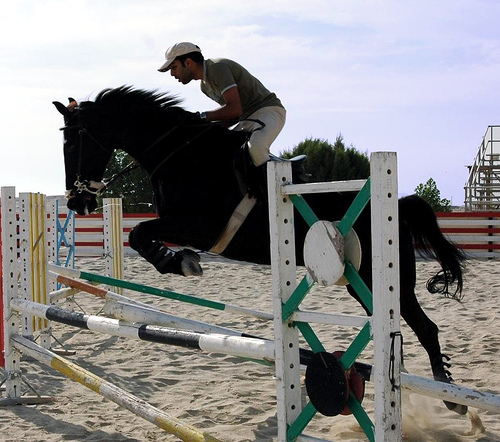

In [7]:
dataset[0][0]

In [8]:
target_names = []

for obj in dataset:
    target_names.extend([x['name'] for x in obj[1]['annotation']['object']])

target_names = list(set(target_names))

In [9]:
target_names

['pottedplant',
 'bus',
 'motorbike',
 'horse',
 'cow',
 'bottle',
 'sheep',
 'train',
 'tvmonitor',
 'car',
 'cat',
 'bird',
 'boat',
 'chair',
 'person',
 'sofa',
 'diningtable',
 'dog',
 'bicycle',
 'aeroplane']

In [10]:
target2idx = {name: i for i, name in enumerate(target_names)}
idx2target = {i: name for i, name in enumerate(target_names)}

target2idx, idx2target

({'pottedplant': 0,
  'bus': 1,
  'motorbike': 2,
  'horse': 3,
  'cow': 4,
  'bottle': 5,
  'sheep': 6,
  'train': 7,
  'tvmonitor': 8,
  'car': 9,
  'cat': 10,
  'bird': 11,
  'boat': 12,
  'chair': 13,
  'person': 14,
  'sofa': 15,
  'diningtable': 16,
  'dog': 17,
  'bicycle': 18,
  'aeroplane': 19},
 {0: 'pottedplant',
  1: 'bus',
  2: 'motorbike',
  3: 'horse',
  4: 'cow',
  5: 'bottle',
  6: 'sheep',
  7: 'train',
  8: 'tvmonitor',
  9: 'car',
  10: 'cat',
  11: 'bird',
  12: 'boat',
  13: 'chair',
  14: 'person',
  15: 'sofa',
  16: 'diningtable',
  17: 'dog',
  18: 'bicycle',
  19: 'aeroplane'})

In [11]:
def target_transform(voc_target):
    target = {}

    target['boxes'] = torch.tensor(
        [
            [
                float(x['bndbox']['xmin']),
                float(x['bndbox']['ymin']),
                float(x['bndbox']['xmax']),
                float(x['bndbox']['ymax'])
            ] for x in voc_target['annotation']['object']
        ],
        dtype=torch.float32
    )
    target['labels'] = torch.tensor([target2idx[x['name']] for x in voc_target['annotation']['object']], dtype=torch.int64)

    return target

In [12]:
target_transform(dataset[0][1])

{'boxes': tensor([[ 53.,  87., 471., 420.],
         [158.,  44., 289., 167.]]),
 'labels': tensor([ 3, 14])}

In [16]:
from torchvision.utils import draw_bounding_boxes


def show(imgs):
    to_pil = T.ToPILImage()

    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 8))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def draw_boxes_single_image(image, boxes, labels):
    colors = ["red" for _ in boxes]

    show(draw_bounding_boxes(image, boxes, labels, colors=colors, width=5))

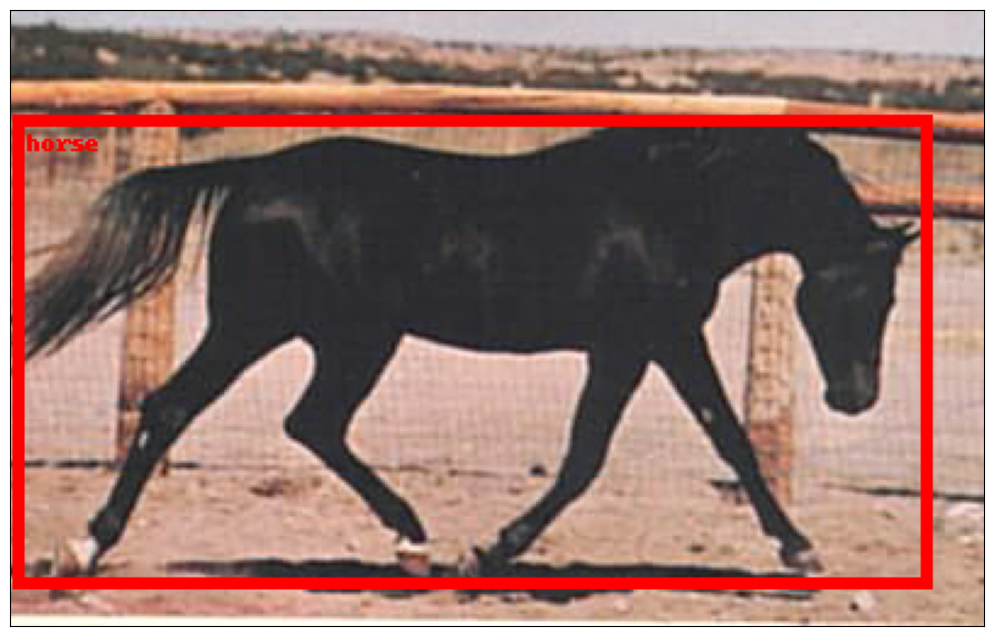

In [17]:
index = 105
draw_boxes_single_image(
    T.PILToTensor()(dataset[index][0]),
    target_transform(dataset[index][1])['boxes'],
    [idx2target[label.item()] for label in target_transform(dataset[index][1])['labels']]
)

In [ ]:
for i in range(1, 10):
    draw_boxes_single_image(
        T.PILToTensor()(dataset[i][0]),
        target_transform(dataset[i][1])['boxes'],
        [idx2target[label.item()] for label in target_transform(dataset[i][1])['labels']]
    )

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset_train = VOCDetection(
    'voc',
    image_set='train',
    transform=T.ToTensor(),
    target_transform=target_transform
)

dataset_test = VOCDetection(
    'voc',
    image_set='val',
    transform=T.ToTensor(),
    target_transform=target_transform
)

train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=8, pin_memory=True, collate_fn=collate_fn)
valid_loader = DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=8, pin_memory=True, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def get_detection_model():
    model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

    model.roi_heads.box_predictor = FastRCNNPredictor(1024, len(target_names))

    return model

In [22]:
model = get_detection_model()

model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 46.4MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [23]:
!pip install -q torchinfo
from torchinfo import summary

summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
FasterRCNN (FasterRCNN)                                           [32, 3, 224, 224]    [0, 4]               --                   Partial
├─GeneralizedRCNNTransform (transform)                            [32, 3, 224, 224]    [32, 3, 320, 320]    --                   --
├─BackboneWithFPN (backbone)                                      [32, 3, 320, 320]    [32, 256, 5, 5]      --                   Partial
│    └─IntermediateLayerGetter (body)                             [32, 3, 320, 320]    [32, 960, 10, 10]    --                   Partial
│    │    └─Conv2dNormActivation (0)                              [32, 3, 320, 320]    [32, 16, 160, 160]   (432)                False
│    │    └─InvertedResidual (1)                                  [32, 16, 160, 160]   [32, 16, 160, 160]   (400)                False
│    │    └─InvertedResidual (2)                

In [24]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import batched_nms


def intersection_over_union(dt_bbox, gt_bbox):
    int_x0 = max(dt_bbox[0], gt_bbox[0])
    int_y0 = max(dt_bbox[1], gt_bbox[1])

    int_x1 = min(dt_bbox[2], gt_bbox[2])
    int_y1 = min(dt_bbox[3], gt_bbox[3])

    intersection = max(int_x1 - int_x0, 0) * max(int_y1 - int_y0, 0)
    dt_area = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    return intersection / (dt_area + gt_area - intersection)


def apply_nms(orig_prediction, iou_thresh=0.3):

    keep = batched_nms(orig_prediction['boxes'], orig_prediction['scores'], orig_prediction['labels'], iou_thresh)

    final_prediction = orig_prediction

    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    to_pil = T.ToPILImage()
    to_tensor = T.PILToTensor()

    xs, ys = batch

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = {k: v.to(device) for k, v in model([x.to(device)])[0].items()}

        prediction = apply_nms(prediction)

        x = to_tensor(to_pil(x.cpu()))

        true_boxes = draw_bounding_boxes(x, boxes=y['boxes'], labels=[idx2target[label.item()] for label in y['labels']], width=5, colors='red')
        predicted_boxes = draw_bounding_boxes(x, boxes=prediction['boxes'], labels=[idx2target[label.item()] for label in prediction['labels']], width=5, colors='red')

        fig, ax = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')

        ax[0].imshow(to_pil(true_boxes))
        ax[1].imshow(to_pil(predicted_boxes))

        ax[0].axis('off')
        ax[1].axis('off')

        ax[0].set_title('Target boxes')
        ax[1].set_title('Predicted boxes')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [25]:
def train(model):
    model.train()

    for x, y in tqdm(train_loader, desc='Train'):
        x = list(_.to(device).float() for _ in x)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]

        optimizer.zero_grad()

        output = model(x, y)

        loss_sum = sum(loss for loss in output.values())

        loss_sum.backward()

        optimizer.step()

In [26]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    metric = MeanAveragePrecision()

    for x, y in tqdm(loader, desc='Evaluation'):
        x = list(_.to(device).float() for _ in x)

        output = model(x)

        output = [{k: v.cpu() for k, v in t.items()} for t in output]

        metric.update(output, y)

    return metric.compute()['map']

In [27]:
def plot_stats(
    train_map,
    valid_map,
    title
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' mAP')

    plt.plot(train_map, label='Train mAP')
    plt.plot(valid_map, label='Valid mAP')
    plt.legend()
    plt.grid()

    plt.show()

In [28]:
def whole_train_valid_cycle(model, num_epochs, title):
    batch = next(iter(valid_loader))

    for epoch in range(num_epochs):
        train(model)

        clear_output()

        visualize(model, batch)

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla T4


In [38]:
model = get_detection_model().to(device)

optimizer = Adam([p for p in model.parameters() if p.requires_grad], lr=1e-4)

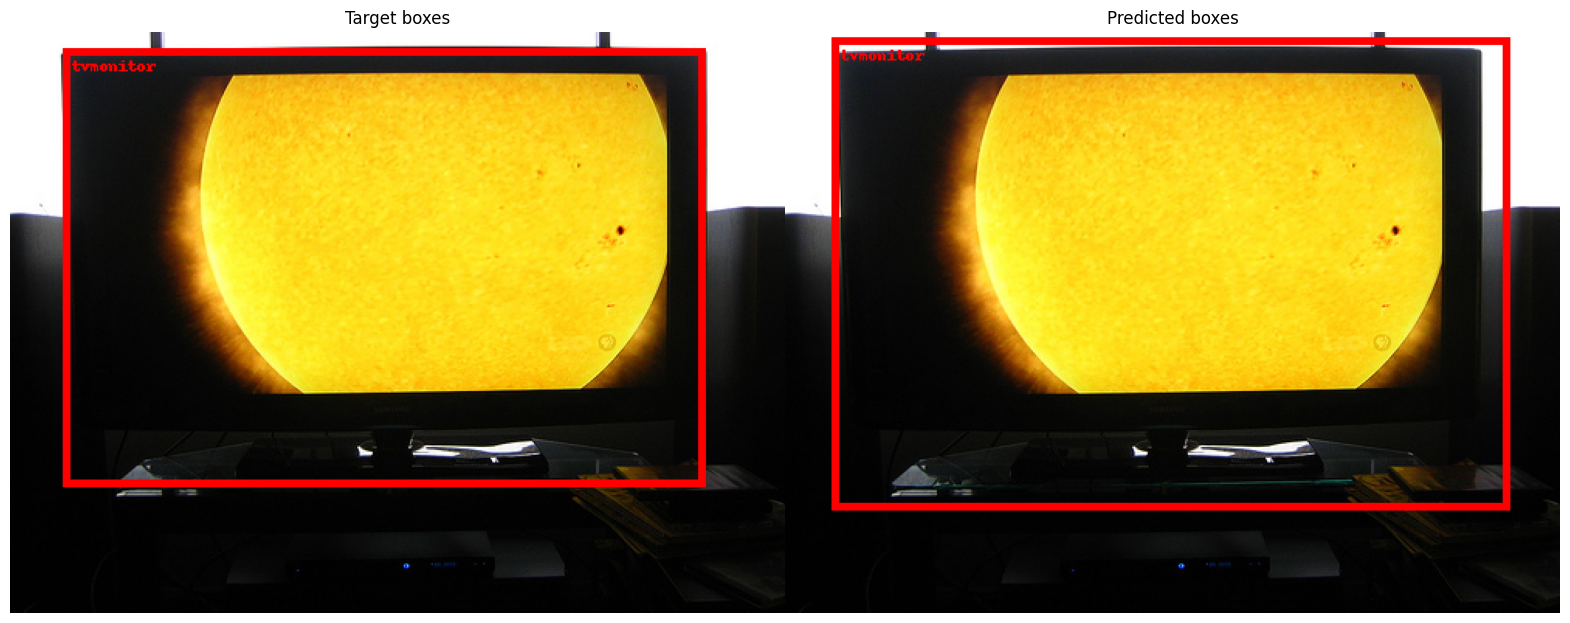

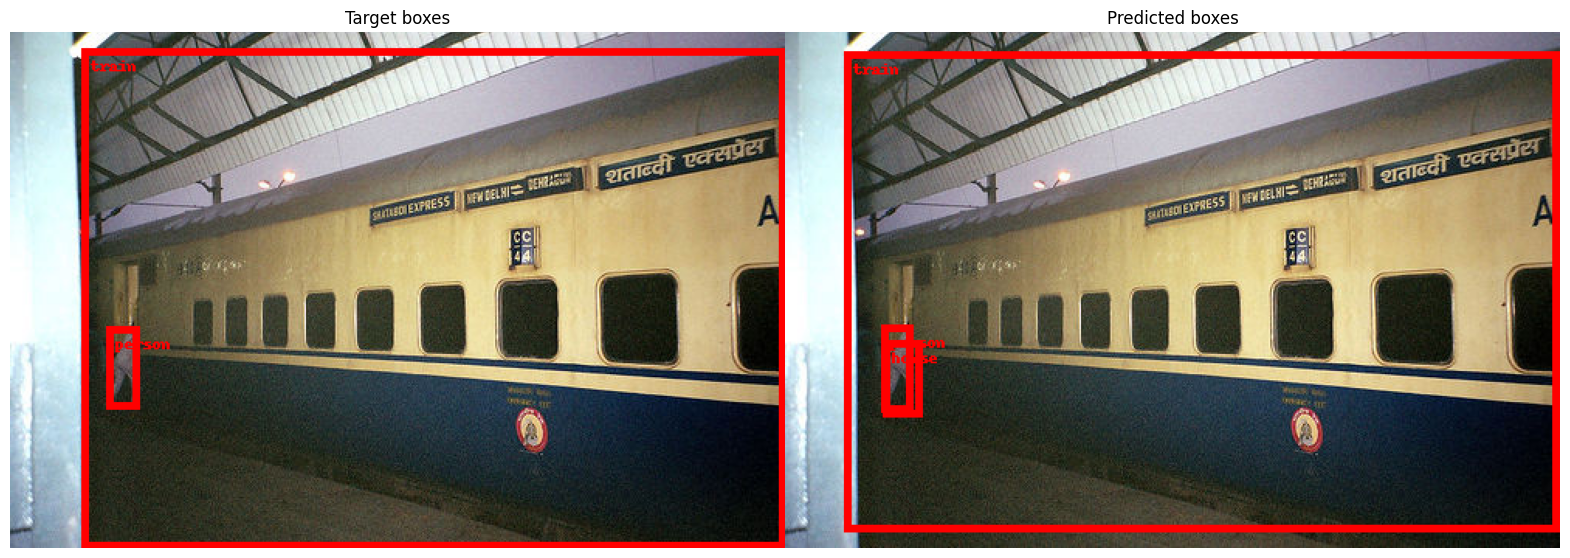

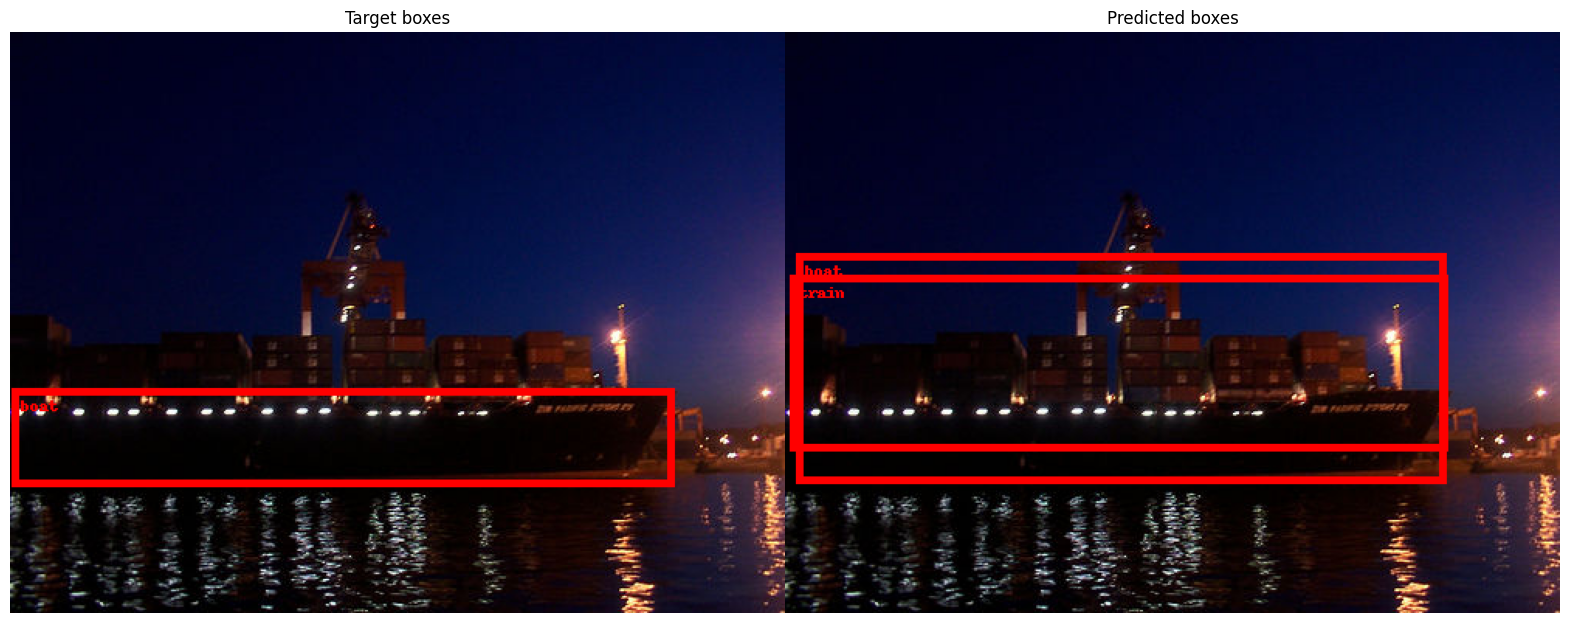

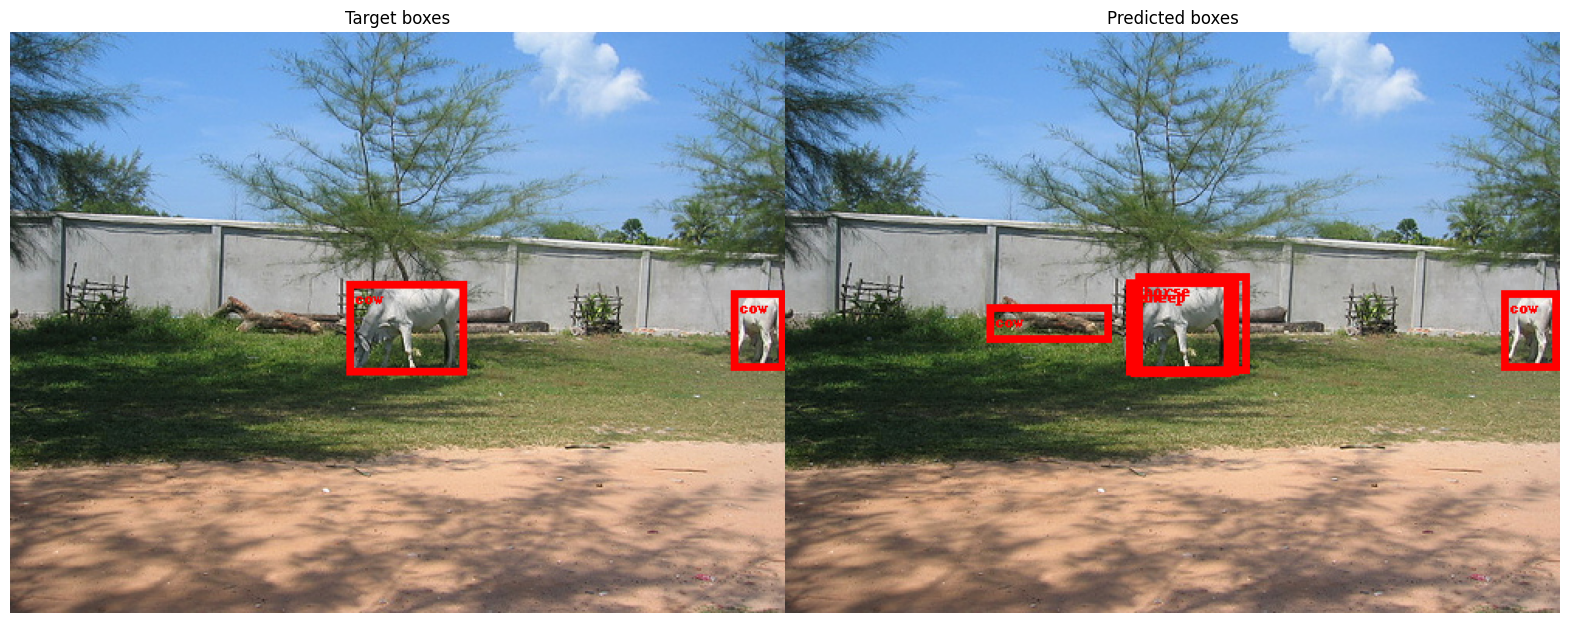

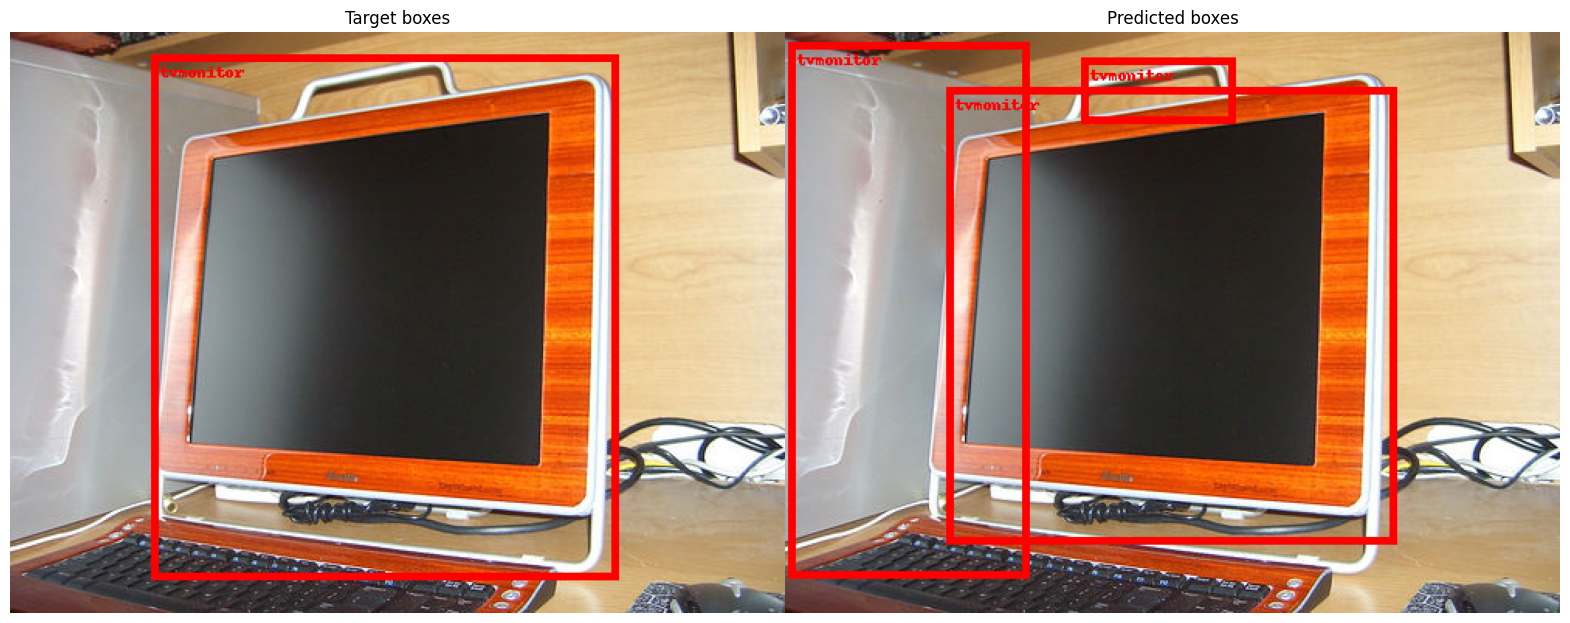

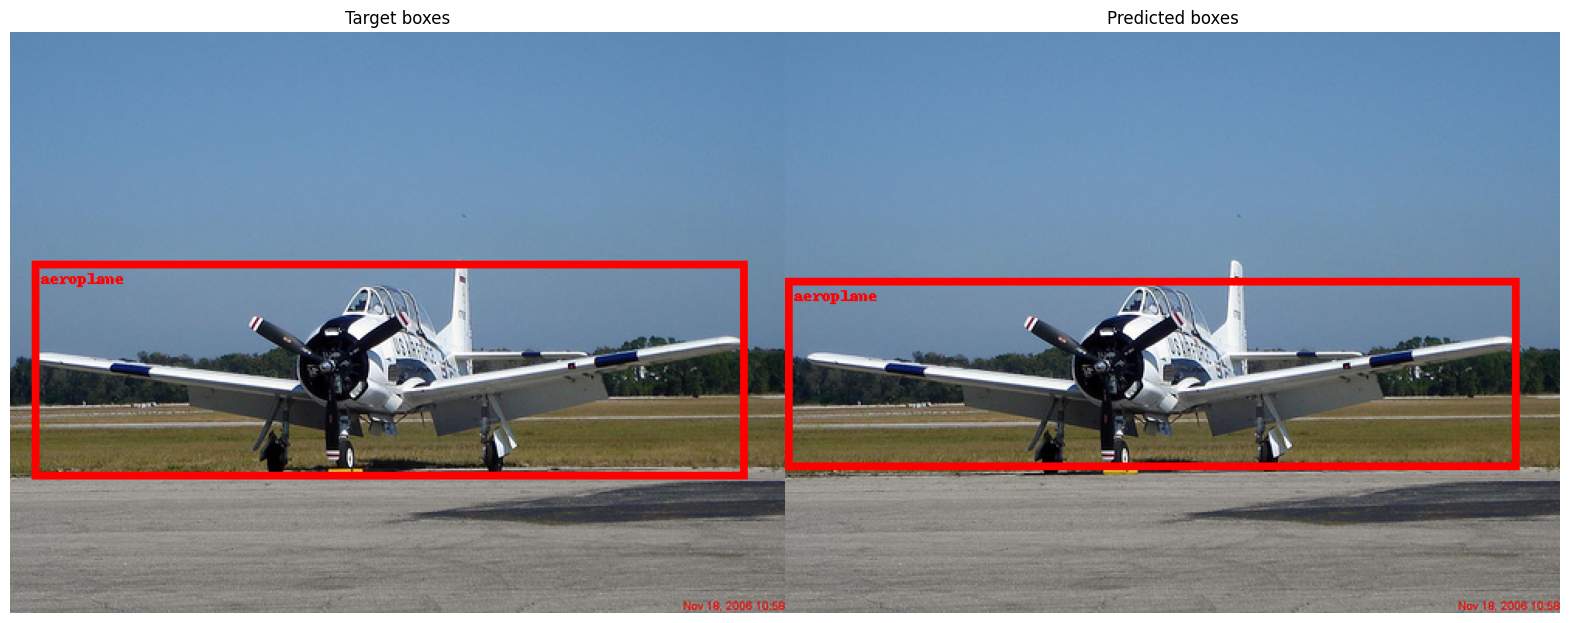

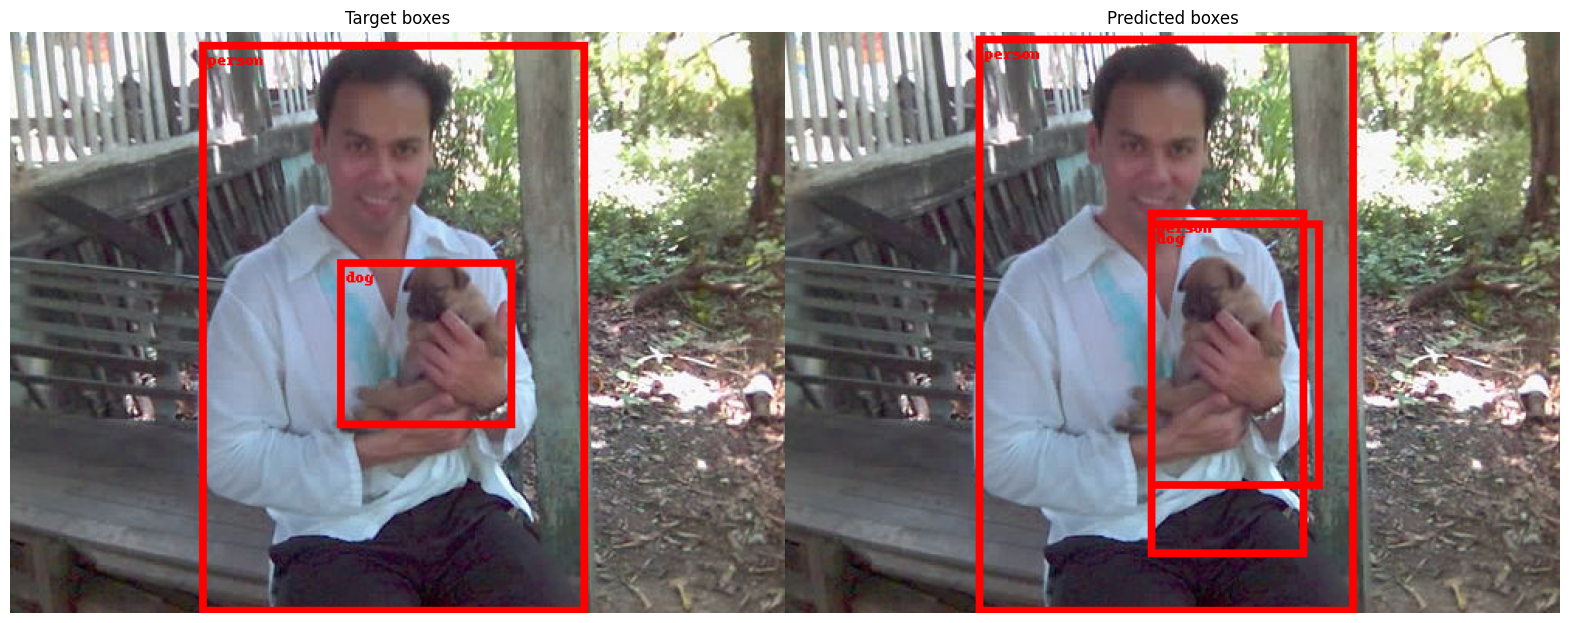

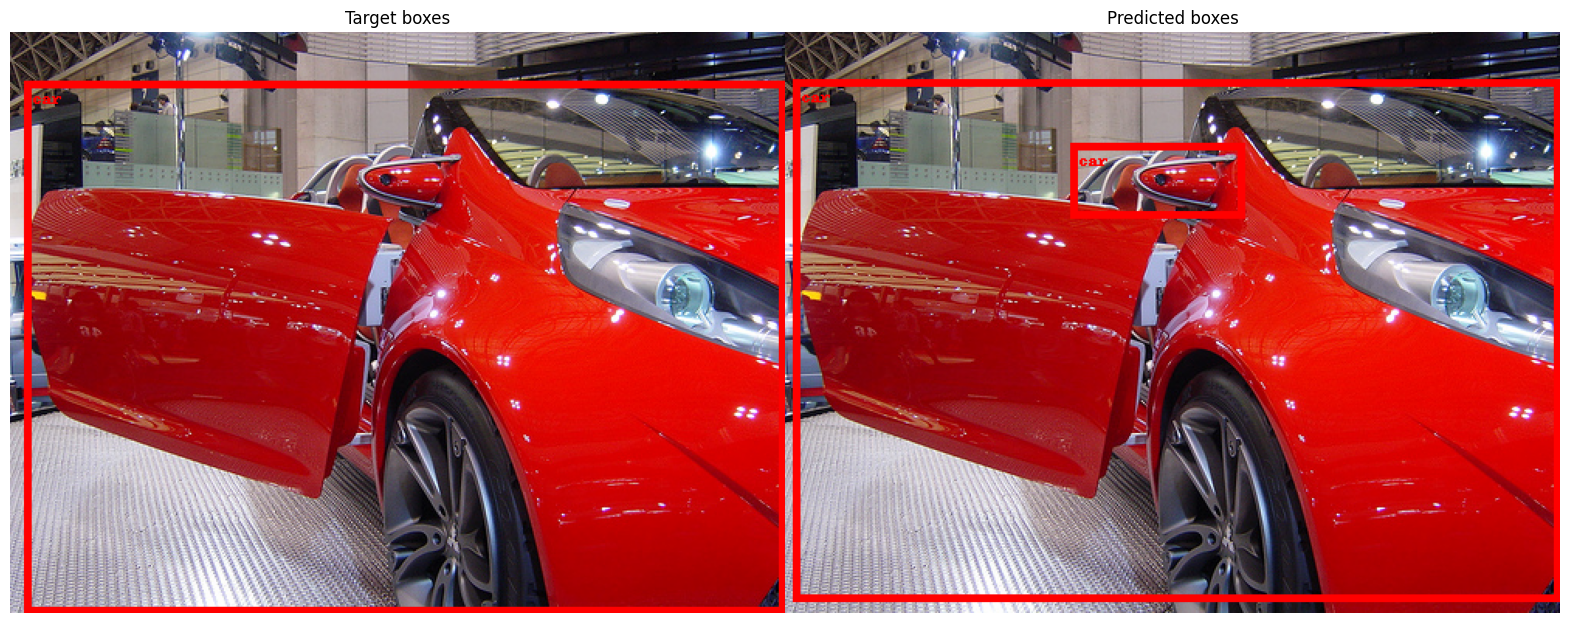

In [39]:
whole_train_valid_cycle(model, 15, 'Faster R-CNN finetune')

In [ ]:
visualize(model, next(iter(train_loader)))

In [ ]:
visualize(model, next(iter(train_loader)))

In [42]:
train_map = evaluate(model, train_loader)
valid_map = evaluate(model, valid_loader)

print(f'Train mAP {train_map:.5f} Valid mAP {valid_map:.5f}')

Evaluation:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/728 [00:00<?, ?it/s]

Train mAP 0.68069 Valid mAP 0.37875
